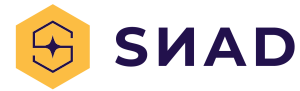

# US baby names dataset

This notebook gives an example of Active Anomaly Detection with `coniferest` and [US baby names](https://www.ssa.gov/OACT/babynames/) dataset.

Developers of `conferest`:
- [Matwey Kornilov (MSU)](https://matwey.name)
- [Vladimir Korolev](https://www.linkedin.com/in/vladimir-korolev-a4195b86/)
- [Konstantin Malanchev (LINCC Frameworks / CMU)](https://homb.it), notebook author

The tutorial is co-authored by [Etienne Russeil (LPC)](https://github.com/erusseil)

**[Run this NB in Google Colab](https://colab.research.google.com/github/snad-space/coniferest/blob/master/docs/notebooks/us-names.ipynb)**

## Install and import modules

In [1]:
%pip install 'coniferest[datasets]' pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from coniferest.pineforest import PineForest
from coniferest.isoforest import IsolationForest
from coniferest.pineforest import PineForest
from coniferest.session import Session
from coniferest.session.callback import TerminateAfter, prompt_decision_callback, Label

/Users/hombit/.virtualenvs/coniferest/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data preparation

Download data and put into a single data frame

In [3]:
%%time

# Hugging Face dataset constructed from
# https://www.ssa.gov/OACT/babynames/state/namesbystate.zip
dataset = datasets.load_dataset("snad-space/us-names-by-state")
raw = dataset['train'].to_pandas()

raw

CPU times: user 352 ms, sys: 149 ms, total: 501 ms
Wall time: 6.59 s


State Gender  Year      Name  Count
0          AK      F  1910      Mary     14
1          AK      F  1910     Annie     12
2          AK      F  1910      Anna     10
3          AK      F  1910  Margaret      8
4          AK      F  1910     Helen      7
...       ...    ...   ...       ...    ...
6600635    WY      M  2024     Royce      5
6600636    WY      M  2024   Spencer      5
6600637    WY      M  2024    Truett      5
6600638    WY      M  2024    Wylder      5
6600639    WY      M  2024    Xander      5

[6600640 rows x 5 columns]

Let's load the data and transform it into a feature matrix where each column is the number (normalized by peak value) of US citizens that got this name in a given year. We apply few quality filter. We require the name to appear at least 10000 times over the full time range, this will prevent noisy data from names that are barely used. 

Optionally, we use first few Fourier terms to better detect "bumps" and "waves" in the time-series.

In [4]:
%%time

WITH_FFT = True

all_years = np.unique(raw['Year'])
all_names = np.unique(raw['Name'])

# Accumulate names over states and genders
counts = raw.groupby(
    ['Name', 'Year'],
).apply(
    lambda df: df['Count'].sum(),
    include_groups=False,
)

# Transform to a data frame where names are labels, years are columns and counts are values (features)
years = [f'year_{i}' for i in all_years]
year_columns = pd.DataFrame(data=0.0, index=all_names, columns=years)
for name, year in counts.index:
    year_columns.loc[name, f'year_{year}'] = counts.loc[name, year]

# Account for total population changes
trend = year_columns.sum(axis=0)
detrended = year_columns / trend

# Normalise and filter
norm = detrended.apply(lambda column: column / detrended.max(axis=1))
filtered = norm[year_columns.sum(axis=1) >= 10_000]

if WITH_FFT:
    # Fourier-transform, normalize by zero frequency and get power-spectrum for few lowest frequencies
    power_spectrum = np.square(np.abs(np.fft.fft(filtered)))
    power_spectrum_norm = power_spectrum / power_spectrum[:, 0, None]
    power_spectrum_low_freq = power_spectrum_norm[:, 1:21]
    frequencies = [f'freq_{i}' for i in range(power_spectrum_low_freq.shape[1])]
    power = pd.DataFrame(data=power_spectrum_low_freq, index=filtered.index, columns=frequencies)

    # Concatenate time-series data and power spectrum
    final = pd.merge(filtered, power, left_index=True, right_index=True)
else:
    # Use time-series data
    final = filtered

final

CPU times: user 30.2 s, sys: 494 ms, total: 30.7 s
Wall time: 30.8 s


year_1910  year_1911  year_1912  year_1913  year_1914  year_1915  \
Aaliyah    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
Aaron      0.045721   0.053748   0.062029   0.077329   0.074982   0.065564   
Abbey      0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
Abbie      0.359963   0.269810   0.306465   0.464630   0.215549   0.302426   
Abbigail   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
...             ...        ...        ...        ...        ...        ...   
Zelma      0.932474   1.000000   0.729411   0.723821   0.652394   0.669621   
Zion       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
Zoe        0.009245   0.000000   0.003225   0.000000   0.001845   0.002542   
Zoey       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
Zuri       0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   

          year_1916  year_1917  year_1918  year_1919  ...   freq_10   freq_11  \
Aaliyah    0.000000   0.000000   0.000000   0.000000  ...  0.007815  0.011471   
Aaron      0.066903   0.066013   0.065492   0.066256  ...  0.000203  0.000332   
Abbey      0.000000   0.000000   0.000000   0.000000  ...  0.003283  0.002742   
Abbie      0.349251   0.307615   0.197811   0.346344  ...  0.000792  0.000478   
Abbigail   0.000000   0.000000   0.000000   0.000000  ...  0.002717  0.001827   
...             ...        ...        ...        ...  ...       ...       ...   
Zelma      0.600106   0.576397   0.536196   0.576366  ...  0.012596  0.010955   
Zion       0.000000   0.000000   0.000000   0.000000  ...  0.022560  0.009141   
Zoe        0.004275   0.004373   0.002134   0.001221  ...  0.010147  0.009064   
Zoey       0.000000   0.000000   0.000000   0.000000  ...  0.010202  0.010542   
Zuri       0.000000   0.000000   0.000000   0.000000  ...  0.041216  0.032491   

           freq_12   freq_13   freq_14   freq_15   freq_16   freq_17  \
Aaliyah   0.009205  0.002661  0.000384  0.003367  0.004686  0.002152   
Aaron     0.000003  0.000209  0.000003  0.000213  0.000325  0.000083   
Abbey     0.000650  0.000279  0.000762  0.000680  0.000231  0.000050   
Abbie     0.000180  0.000260  0.001956  0.000199  0.000055  0.000111   
Abbigail  0.001172  0.001199  0.001423  0.001123  0.000468  0.000081   
...            ...       ...       ...       ...       ...       ...   
Zelma     0.009435  0.007556  0.005983  0.005520  0.005827  0.005979   
Zion      0.002182  0.006346  0.010988  0.008036  0.002212  0.001621   
Zoe       0.004659  0.001311  0.001038  0.002035  0.002939  0.003169   
Zoey      0.008716  0.005578  0.002431  0.000437  0.000107  0.000786   
Zuri      0.029391  0.026944  0.022914  0.018828  0.013810  0.008968   

           freq_18   freq_19  
Aaliyah   0.000062  0.000980  
Aaron     0.000084  0.000259  
Abbey     0.000016  0.000096  
Abbie     0.000089  0.000495  
Abbigail  0.000061  0.000128  
...            ...       ...  
Zelma     0.005959  0.006366  
Zion      0.005530  0.006818  
Zoe       0.002656  0.002130  
Zoey      0.001459  0.001728  
Zuri      0.007011  0.007291  

[2337 rows x 135 columns]

Plotting function

In [5]:
def basic_plot(idx):
    cols = [col.startswith('year') for col in final.columns]
    all_years = [int(col.removeprefix('year_')) for col in final.columns[cols]]

    if isinstance(idx, str):
        counts = final.loc[idx][cols]
        title = idx
    else:
        counts = final.iloc[idx][cols]
        title = final.iloc[idx].name

    plt.plot(all_years, counts.values)
    # plt.ylim(-0.1, 1.1)
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.show()

We can now easily look at the evolution of a given name over the years

2337


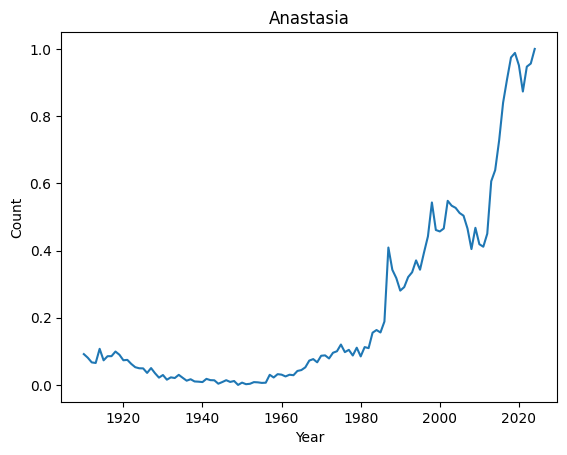

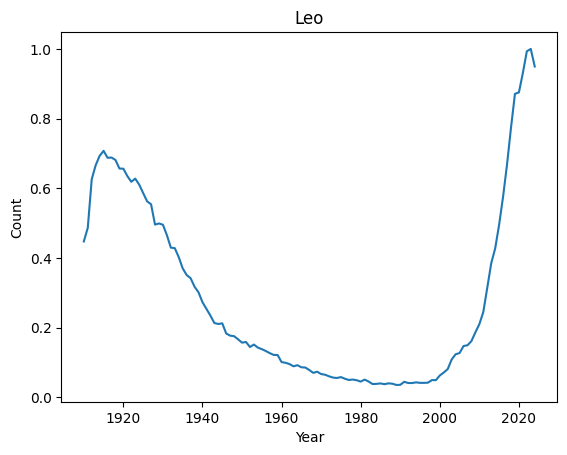

In [6]:
print(len(final))
basic_plot('Anastasia')
basic_plot('Leo')

## Classical anomaly detection

In [7]:
model = IsolationForest(random_seed=1, n_trees=1000)
model.fit(np.array(final))
scores = model.score_samples(np.array(final))
ordered_scores, ordered_index = zip(*sorted(zip(scores, final.index)))

print(f"Top 10 weirdest names : {ordered_index[:10]}")
print(f"Top 10 most regular names : {ordered_index[-10:]}")

Top 10 weirdest names : ('Manuel', 'Marshall', 'Alfonso', 'Vincent', 'Margarita', 'Byron', 'Rudy', 'Benito', 'Peter', 'Ruben')
Top 10 most regular names : ('Kian', 'Jayla', 'Kenzie', 'Ibrahim', 'Teagan', 'Phoenix', 'Kaliyah', 'Holden', 'Cali', 'Raegan')


Let's have a look at their distributions

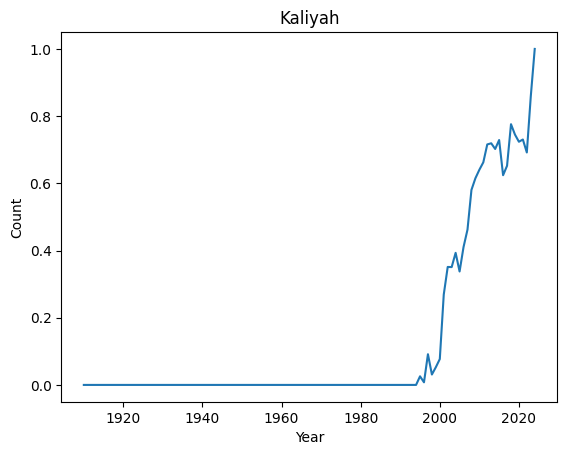

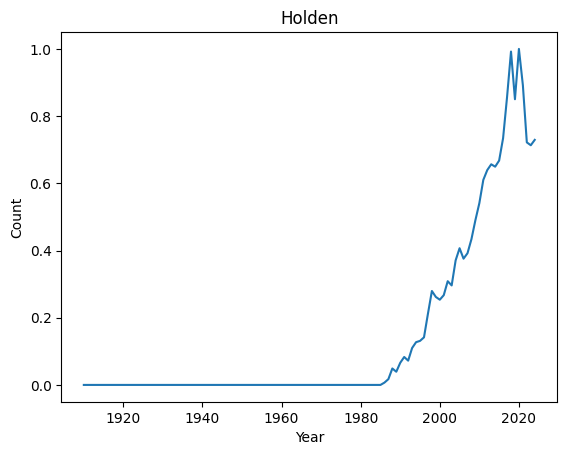

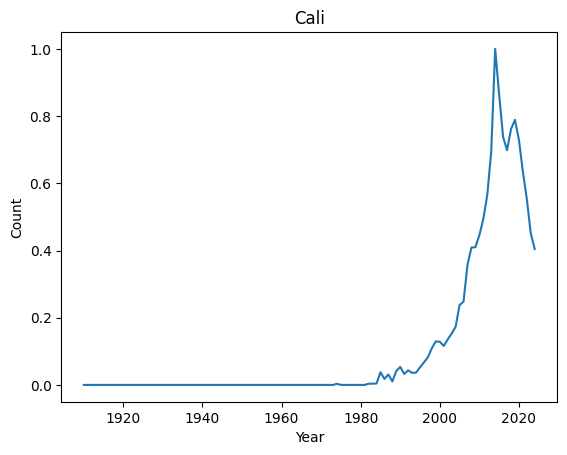

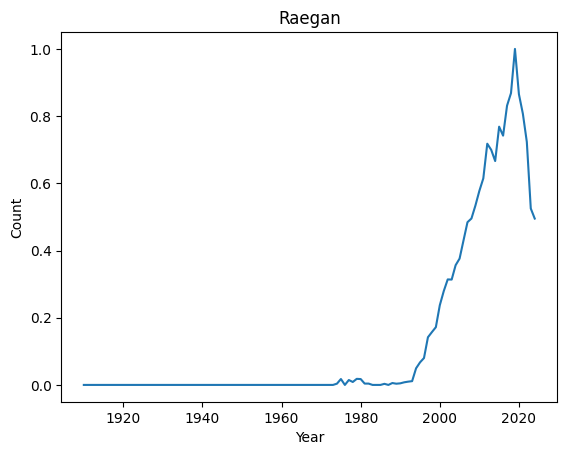

In [8]:
for normal in ordered_index[-4:]:
    basic_plot(normal)

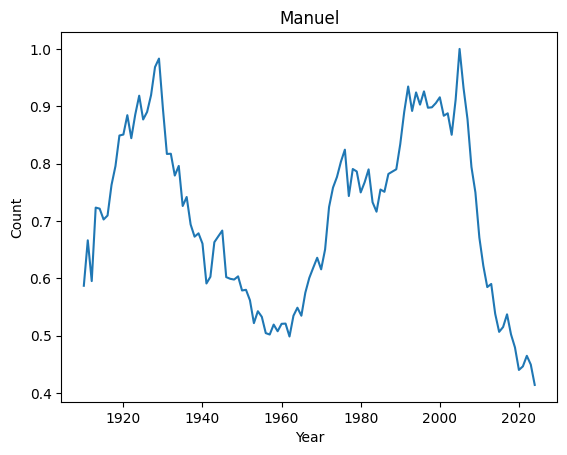

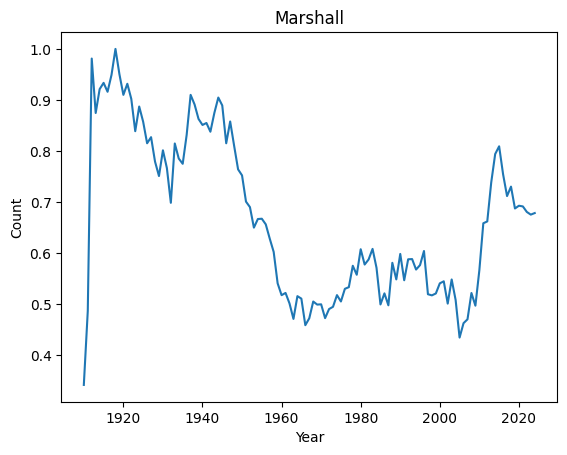

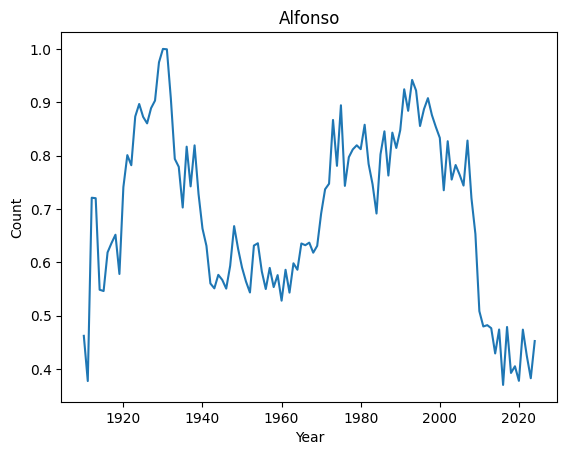

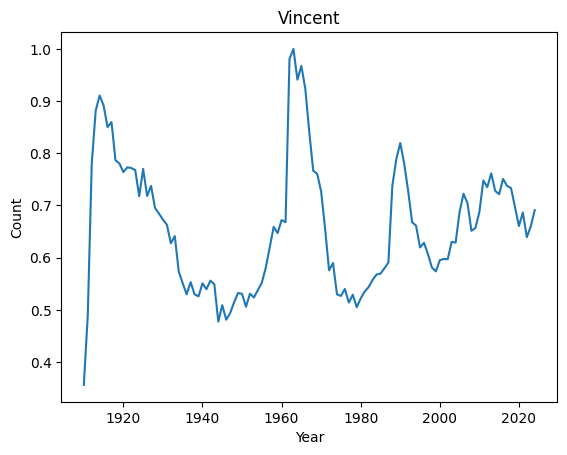

In [9]:
for weird in ordered_index[:4]:
    basic_plot(weird)

It seems that anomalies are either very localised peak or very recent trending names.

## Active Anomaly Detection 

First, we need a function helping us to make a decision.

### Comment dummy decision function and uncomment interactive one

In [10]:
# Comment
def help_decision(metadata, data, session):
    """Dummy, says YES to everything"""
    return Label.ANOMALY

### UNCOMMENT
# def help_decision(metadata, data, session):
#     """Plots data and asks expert interactively"""
#     basic_plot(metadata)
#     return prompt_decision_callback(metadata, data, session)

Let's create a model and run a session

Let's run PineForest and say YES every time we see a recent growth

In [11]:
model = PineForest(
    # Number of trees to use for predictions
    n_trees=256,
    # Number of new trees to grow for each decision
    n_spare_trees=768,
    # Fix random seed for reproducibility
    random_seed=0,
)
session = Session(
    data=final,
    metadata=final.index,
    model=model,
    decision_callback=help_decision,
    on_decision_callbacks=[
        TerminateAfter(10),
    ],
)
session.run()

Wow! Good almost 100% of the behavior we were looking for

Now we can run it again and say YES every time we see a sharp peak

In [12]:
model = PineForest(
    # Number of trees to use for predictions
    n_trees=256,
    # Number of new trees to grow for each decision
    n_spare_trees=768,
    # Fix random seed for reproducibility
    random_seed=0,
)
session = Session(
    data=final,
    metadata=final.index,
    model=model,
    decision_callback=help_decision,
    on_decision_callbacks=[
        TerminateAfter(20),
    ],
)
session.run()

PineForest learns the profile interesting for the user and outputs it.

Try to change Pineforest hyperparameters and see how results change. Try different random seeds and number of trees.